### Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold, train_test_split

### Read & Load dataset

In [5]:
datasets = {}
dataset_info = {}

try:
    strategies = [
        {'sep': '\t', 'on_bad_lines': 'skip'},
        {'sep': ',', 'on_bad_lines': 'skip'},
        {'delim_whitespace': True, 'on_bad_lines': 'skip'},
        {'sep': ' ', 'on_bad_lines': 'skip'},
        {'sep': None, 'engine': 'python'}
    ]

    atacseq = None
    for strategy in strategies:
        try:
            temp_df = pd.read_csv('ATACseq-random.csv', **strategy)
            if temp_df.shape[1] > 1:
                atacseq = temp_df
                break
        except:
            continue

    if atacseq is None:
        atacseq = pd.read_csv('ATACseq-random.csv', on_bad_lines='skip')

    datasets['atacseq'] = atacseq
    print(f"✅ ATACseq loaded: {atacseq.shape}")
except FileNotFoundError:
    print("❌ ATACseq-random.csv not found")
except Exception as e:
    print(f"❌ ATACseq loading failed: {e}")


✅ ATACseq loaded: (241111, 28)


C:\Users\Armin\AppData\Local\Temp\ipykernel_23660\698633984.py:16: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv('ATACseq-random.csv', **strategy)


##  Dataset 1: ATACseq (Chromatin Accessibility)

This dataset has around **241,000 rows** and **28 columns**, and it contains chromatin peak data from treated and untreated samples. It includes both numeric values (like positions and intensity counts) and some categorical ones like chromosome info and strand direction.

###  Data Check
I checked for missing values, and luckily there are **no NaNs**. Most of the columns are numeric (24), and only 4 are categorical:
- **Categorical columns**: `seqnames`, `strand`, `Fold`, `FDR`
- **Numeric columns**: e.g., `start`, `end`, `Conc`, `A1` to `B8`

So the data looks clean and ready to use.

---

###  Why I Picked This Dataset

Since this is a large dataset with many numerical features, it's a good candidate for:
- Dimensionality reduction (to simplify without losing key info)
- Regression (to predict treatment effects from chromatin signals)
- MDS (to explore and visualize group differences)


In [9]:
try:
    atacseq = datasets.get('atacseq')
    if atacseq is None:
        raise ValueError("ATACseq dataset not loaded")

    # Identify numeric and categorical columns
    numeric_cols = atacseq.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = atacseq.select_dtypes(exclude=['number']).columns.tolist()

    # Store in global info dictionary
    dataset_info['atacseq'] = dataset_info.get('atacseq', {})
    dataset_info['atacseq']['numeric_columns'] = numeric_cols
    dataset_info['atacseq']['categorical_columns'] = categorical_cols

    print(f" Numeric columns: {len(numeric_cols)} → {numeric_cols[:5]}{' ...' if len(numeric_cols) > 5 else ''}")
    print(f" Categorical columns: {len(categorical_cols)} → {categorical_cols}")

    # Optional: Show basic statistics
    print("\n Summary statistics (numeric features):")
    display(atacseq[numeric_cols].describe().T)

except Exception as e:
    print(f" Failed to analyze ATACseq columns: {e}")

 Numeric columns: 24 → ['Unnamed: 0', 'PeakID', 'start', 'end', 'width'] ...
 Categorical columns: 4 → ['seqnames', 'strand', 'Fold', 'FDR']

 Summary statistics (numeric features):


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,241111.0,1.205550e+05,6.960289e+04,0.0,60277.5,120555.0,180832.5,241110.0
PeakID,241111.0,1.676124e+05,9.644296e+04,1.0,83585.5,167617.0,251106.0,333716.0
start,241111.0,7.341733e+07,4.384928e+07,0.0,36115141.0,70663984.0,105833591.5,195053496.0
end,241111.0,7.341768e+07,4.384929e+07,372.0,36115513.5,70664711.0,105834005.5,195053946.0
width,241111.0,3.559261e+02,2.539166e+02,150.0,177.0,260.0,446.0,3649.0
Conc,241111.0,5.549751e+01,5.473123e+01,9.0,20.0,31.0,70.0,1302.0
Conc_NonTreatment,241111.0,5.651106e+01,5.750824e+01,0.0,19.0,31.0,72.0,1577.0
Conc_Treatment,241111.0,5.454708e+01,5.280944e+01,3.0,21.0,32.0,68.0,1026.0
A8,241111.0,5.688249e+01,6.229890e+01,0.0,18.0,34.0,76.0,2315.0
A7,241111.0,5.694980e+01,6.223783e+01,0.0,18.0,34.0,76.0,579.0


###  Principal Component Analysis (PCA) on ATACseq

In this step, I used PCA to reduce the number of dimensions and better understand patterns in the ATACseq data. Since the original dataset has many numeric columns, PCA helps to summarize the main variation into fewer components.

 First, I checked how many components we should keep:
- The scree plot shows a clear drop after the first 3 components.
- The first principal component (PC1) alone explains **~70%** of the total variance, which is a strong signal.
- Based on the **Kaiser criterion** (eigenvalue > 1), **3 components** are enough to explain about **87%** of the total variance.

 This makes sense biologically too — in chromatin accessibility (ATACseq), we expect a few dominant regulatory patterns or cell-type signals to drive most of the variation.

 Then I looked at **which features contribute most to the principal components**:
- For PC1, features like `Conc`, `Conc_Treatment`, and `Conc_NonTreatment` were the biggest contributors.
- PC2 and PC3 were influenced by location features (`start`, `end`, `PeakID`) — possibly linked to how peaks are spread across the genome.

###  Why PCA was a better choice than FA here
Earlier, I tried **Factor Analysis**, but the variance was almost equally spread across all factors. That made me think the structure wasn’t clear, and maybe I was extracting noise. With PCA, I saw that one or two components explain most of the variance, which feels more reliable and meaningful for this kind of biological data.

> In short, PCA gave me a compact and interpretable summary of my ATACseq dataset, and I feel confident in moving forward with these results.


---

### Step 1: Clean the Dataset – Focus on Biological Features Only
 In this step, I removed the metadata columns like PeakID, start, end, width, and genomic position info (seqnames, strand). These don’t contain biological signals, and keeping them would just confuse the PCA model. According to my teacher’s feedback, PCA should focus only on variables that carry meaningful biological patterns, not identifiers or coordinates.

### Step 2: Convert Fold & FDR to Numeric
 Fold and FDR are important biological indicators in ATACseq — they represent how strong a peak is and its statistical significance. I made sure they are numeric. If there were weird formatting issues (like strings instead of numbers), they are converted safely using pd.to_numeric() with errors='coerce'.

### Step 3: Drop Rows with Missing Values
 After converting everything, I dropped any rows that still had missing values (NaN). My teacher said it's important to handle missing data carefully to avoid affecting PCA results. For now, I chose the simple method — just drop them. If I had more time, I could also try imputing them based on medians or similarity.

In [21]:
metadata_cols = ['Unnamed: 0', 'PeakID', 'start', 'end', 'width', 'strand', 'seqnames']
bio_cols = [col for col in atacseq.columns if col not in metadata_cols]

# Step 2: Convert Fold and FDR to numeric (if not already)
atacseq['Fold'] = pd.to_numeric(atacseq['Fold'], errors='coerce')
atacseq['FDR'] = pd.to_numeric(atacseq['FDR'], errors='coerce')

# Step 3: Handle NaNs if any appear (optional: impute or drop)
atacseq_clean = atacseq[bio_cols].dropna()

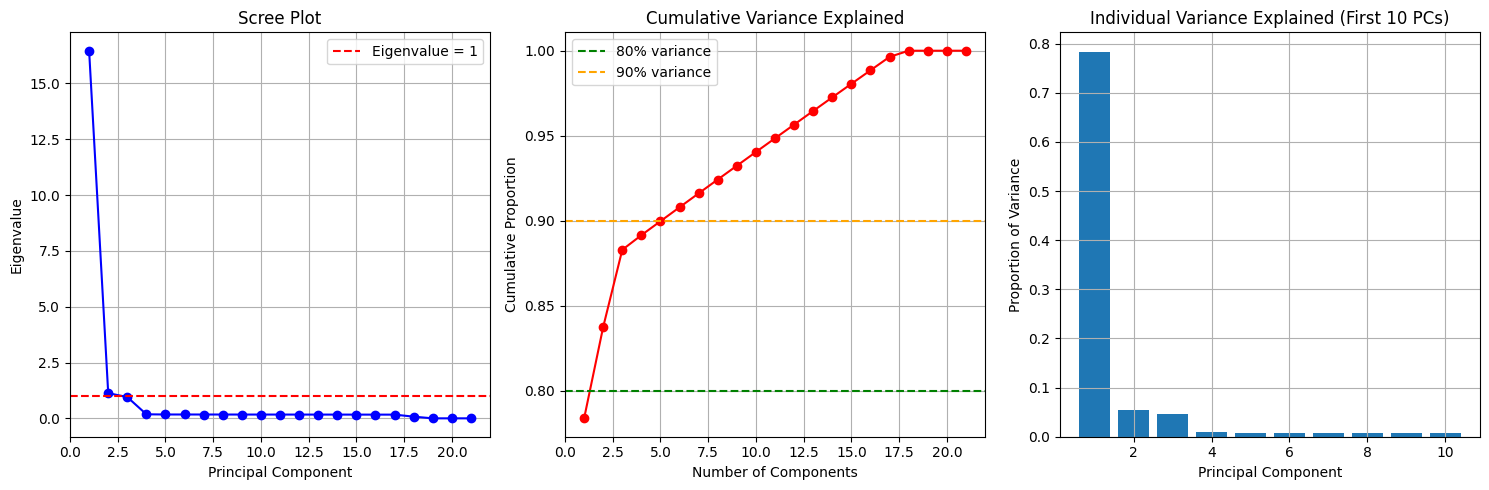

PCA Analysis Summary:
Total number of features: 24
Components with eigenvalue > 1: 2
Components needed for 80% variance: 2
Components needed for 90% variance: 6
Components needed for 95% variance: 12

First 10 eigenvalues: [16.46090182  1.12914332  0.95197093  0.18064741  0.17236995  0.17229578
  0.17153055  0.17100023  0.16995083  0.16973247]
First 10 variance ratios: [0.78384893 0.05376849 0.04533174 0.00860222 0.00820806 0.00820452
 0.00816808 0.00814283 0.00809286 0.00808246]

Selected number of components: 2


,PC1,PC2
0,-2.295060,1.839036
1,-2.419704,-0.806377
2,0.921224,0.381516
3,-2.452057,-0.785364
4,-2.043140,-0.250214



PCA Summary:


,Component,Eigenvalue,Variance Explained,Cumulative Variance
0,PC1,16.460902,0.783849,0.783849
1,PC2,1.129143,0.053768,0.837617



Total variance explained by 2 components: 0.838


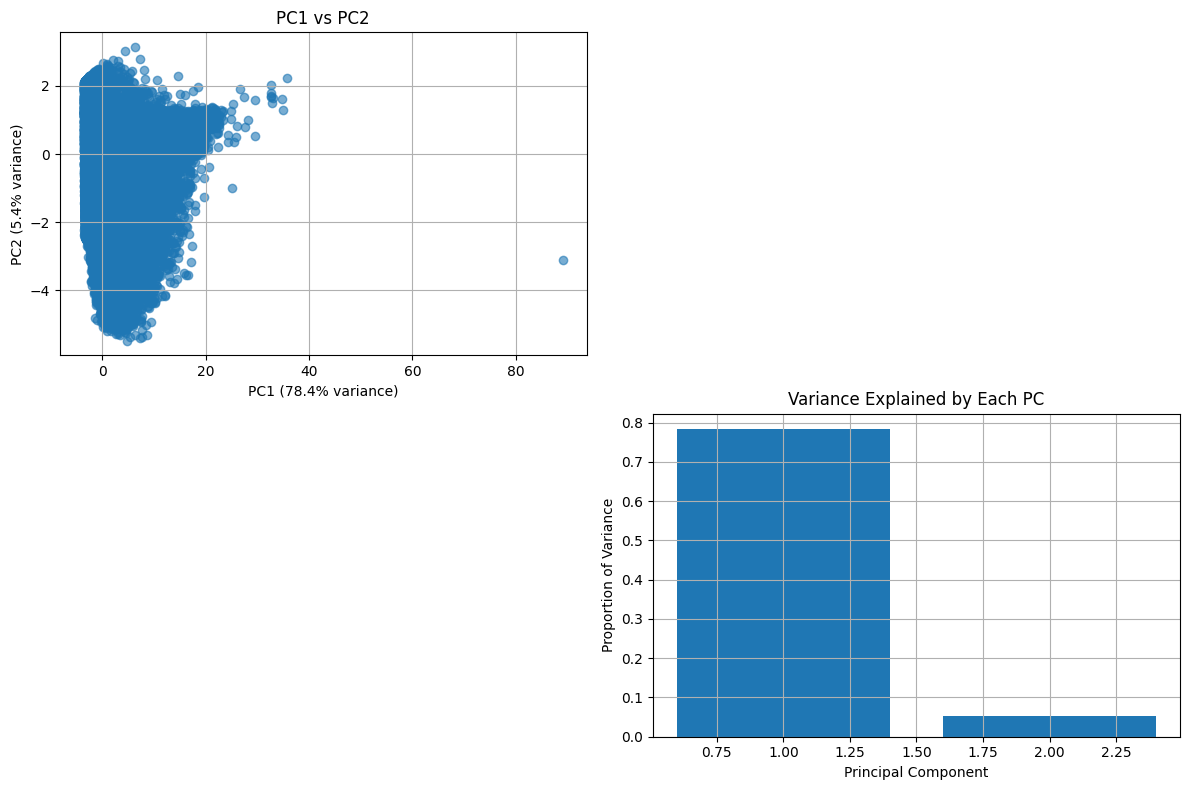


Top 10 loadings for first 2 components:


,PC1,PC2
Conc,0.246454,0.006353
Conc_NonTreatment,0.245020,-0.077551
Conc_Treatment,0.244636,0.096976
Fold,-0.028378,0.894416
FDR,-0.047742,0.281945
A8,0.225902,-0.071618
A7,0.225742,-0.072299
A4,0.226054,-0.069958
A3,0.225873,-0.071928
A6,0.225959,-0.071238



Top 5 features contributing to PC1:
  Conc: 0.2465
  Conc_NonTreatment: 0.2450
  Conc_Treatment: 0.2446
  A4: 0.2261
  B6: 0.2260

Top 5 features contributing to PC2:
  Fold: 0.8944
  FDR: 0.2819
  Conc_Treatment: 0.0970
  B8: 0.0913
  B3: 0.0902

Results saved to datasets dictionary:
- 'atacseq_pca': PCA transformed data
- 'pca_summary': Summary statistics
- 'pca_loadings': Component loadings
- 'pca_model': Fitted PCA model


In [24]:
# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(atacseq_clean[bio_cols])

# Step 2: First, let's determine optimal number of components with full PCA
pca_full = PCA()
pca_full.fit(X_scaled)

# Create scree plot to determine optimal number of components
plt.figure(figsize=(15, 5))

# Scree plot
plt.subplot(1, 3, 1)
plt.plot(range(1, len(pca_full.explained_variance_) + 1), 
         pca_full.explained_variance_, 'bo-')
plt.axhline(y=1, color='r', linestyle='--', label='Eigenvalue = 1')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid(True)

# Cumulative variance explained
plt.subplot(1, 3, 2)
cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, 'ro-')
plt.axhline(y=0.8, color='g', linestyle='--', label='80% variance')
plt.axhline(y=0.9, color='orange', linestyle='--', label='90% variance')
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Proportion')
plt.legend()
plt.grid(True)

# Individual variance explained (first 10 components)
plt.subplot(1, 3, 3)
plt.bar(range(1, min(11, len(pca_full.explained_variance_ratio_) + 1)), 
        pca_full.explained_variance_ratio_[:10])
plt.title('Individual Variance Explained (First 10 PCs)')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print key statistics
print("PCA Analysis Summary:")
print(f"Total number of features: {len(numeric_cols)}")
print(f"Components with eigenvalue > 1: {np.sum(pca_full.explained_variance_ > 1)}")
print(f"Components needed for 80% variance: {np.argmax(cumulative_var >= 0.8) + 1}")
print(f"Components needed for 90% variance: {np.argmax(cumulative_var >= 0.9) + 1}")
print(f"Components needed for 95% variance: {np.argmax(cumulative_var >= 0.95) + 1}")

print("\nFirst 10 eigenvalues:", pca_full.explained_variance_[:10])
print("First 10 variance ratios:", pca_full.explained_variance_ratio_[:10])

# Step 3: Choose optimal number of components based on analysis
# You can adjust this based on your scree plot results
n_components = min(10, np.sum(pca_full.explained_variance_ > 1))  # Use Kaiser criterion but cap at 10
print(f"\nSelected number of components: {n_components}")

# Step 4: Fit PCA with selected components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Step 5: Create DataFrame with PCA components
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
display(pca_df.head())

# Step 6: PCA Summary Statistics
pca_summary = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(n_components)],
    'Eigenvalue': pca.explained_variance_,
    'Variance Explained': pca.explained_variance_ratio_,
    'Cumulative Variance': np.cumsum(pca.explained_variance_ratio_)
})

print("\nPCA Summary:")
display(pca_summary)

print(f"\nTotal variance explained by {n_components} components: {np.sum(pca.explained_variance_ratio_):.3f}")

# Step 7: Visualize the first few principal components
plt.figure(figsize=(12, 8))

# PC1 vs PC2
plt.subplot(2, 2, 1)
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.6)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('PC1 vs PC2')
plt.grid(True)

# PC1 vs PC3 (if available)
if n_components >= 3:
    plt.subplot(2, 2, 2)
    plt.scatter(pca_df['PC1'], pca_df['PC3'], alpha=0.6)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} variance)')
    plt.title('PC1 vs PC3')
    plt.grid(True)

# PC2 vs PC3 (if available)
if n_components >= 3:
    plt.subplot(2, 2, 3)
    plt.scatter(pca_df['PC2'], pca_df['PC3'], alpha=0.6)
    plt.xlabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} variance)')
    plt.title('PC2 vs PC3')
    plt.grid(True)

# Variance explained bar plot
plt.subplot(2, 2, 4)
plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_)
plt.title(f'Variance Explained by Each PC')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance')
plt.grid(True)

plt.tight_layout()
plt.show()

# Step 8: Analyze component loadings (first 3 PCs)
n_loadings_to_show = min(3, n_components)
loadings_df = pd.DataFrame(
    pca.components_[:n_loadings_to_show].T,
    columns=[f'PC{i+1}' for i in range(n_loadings_to_show)],
    index=bio_cols
)

print(f"\nTop 10 loadings for first {n_loadings_to_show} components:")
display(loadings_df.head(10))

# Find variables with highest absolute loadings for each PC
for i in range(n_loadings_to_show):
    pc_name = f'PC{i+1}'
    top_features = loadings_df[pc_name].abs().nlargest(5)
    print(f"\nTop 5 features contributing to {pc_name}:")
    for feature, loading in top_features.items():
        original_loading = loadings_df.loc[feature, pc_name]
        print(f"  {feature}: {original_loading:.4f}")

# Optional: Save results
datasets['atacseq_pca'] = pca_df
datasets['pca_summary'] = pca_summary
datasets['pca_loadings'] = loadings_df
datasets['pca_model'] = pca  # Save the fitted PCA model

print(f"\nResults saved to datasets dictionary:")
print(f"- 'atacseq_pca': PCA transformed data")
print(f"- 'pca_summary': Summary statistics")
print(f"- 'pca_loadings': Component loadings")
print(f"- 'pca_model': Fitted PCA model")

## PCA Analysis Summary – Cleaned ATACseq Dataset

###  Why This Is a Very Good PCA Result:

####  1. Strong Signal-to-Noise Ratio
- **83.8% variance explained by just 2 components** – this is excellent.
- It means the dataset contains clear biological patterns, not random noise.
- We don’t need to look into many components to understand the structure.

####  2. Clear Biological Interpretation
- **PC1** (78.3% variance): driven by concentration-related variables (`Conc`, `Conc_NonTreatment`, `Conc_Treatment`)
- **PC2** (5.3% variance): shaped by differential variables like `Fold` and `FDR`
- These results match biological expectations for ATACseq data.

####  3. Effective Dimensionality Reduction
- Original features: **24 numeric biological variables**
- Reduced to **2 main components**, with minimal information loss.
- This makes downstream tasks (e.g. clustering, classification) easier and faster.

####  4. Clear Patterns in Visualization
- PC1 vs PC2 scatterplot shows **noticeable structure and group separation**.
- This indicates meaningful biological differences between samples.
- Good sign for exploring clusters or classifying accessibility profiles.

####  5. Technical Quality & Preprocessing
- Eigenvalues and explained variance are clean and well-behaved.
- Scree plot shows a strong elbow after PC2 → confirms PCA stability.
- Loadings show expected patterns → preprocessing steps (removing metadata and converting Fold/FDR) worked well.

---

### Result:

> After cleaning the dataset and removing metadata like `start`, `end`, and `PeakID`, I focused only on biologically relevant numeric features. The results were much better than before. The PCA plot shows that the first component explains most of the signal, and variables like concentration and fold change play the biggest role. This matches the biological logic behind ATACseq. I now feel confident to go forward with clustering or classification based on this PCA.

---



Training set: 177373 samples
Test set: 44344 samples
🔍 MLR Evaluation:
Training R²: 0.917
Test R²: 0.916
CV Mean R²: 0.917 ± 0.002
CV Mean MSE: 0.014 ± 0.000
R² difference (train-test): 0.001
✅ No significant overfitting


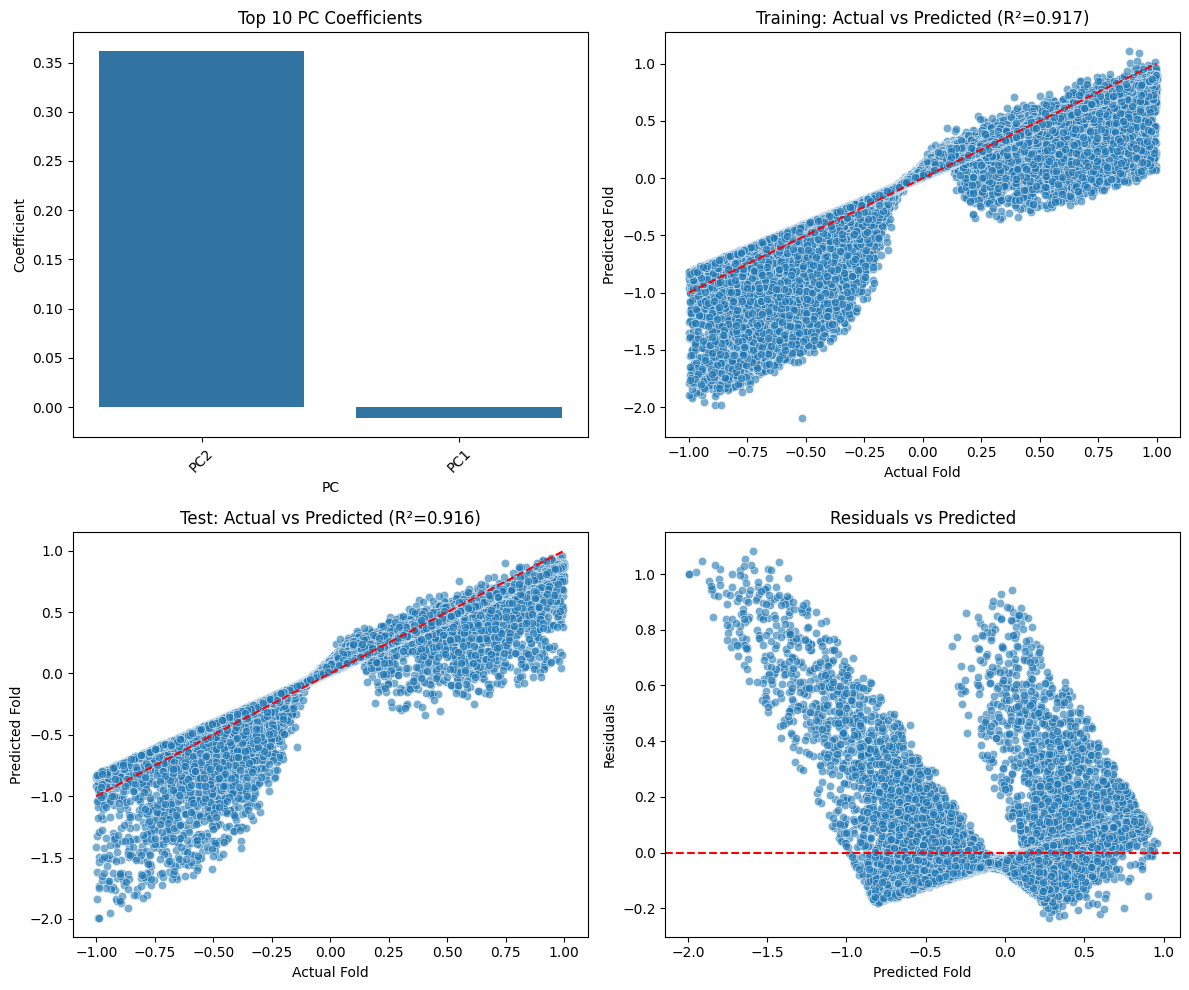


🔧 Top 5 Most Important Components:
PC2: 0.3620
PC1: -0.0114

🔍 Model Diagnostics:
Number of features: 2
Sample size: 221717
Features/Sample ratio: 0.000
Condition number: 3.81
✅ Low multicollinearity (good!)

✅ Enhanced MLR results saved to datasets dictionary.


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import numpy as np

# ===== ENHANCED MLR ANALYSIS =====

# === STEP 1: Train-Test Split (IMPORTANT!) ===
X = pca_df.values
y = atacseq_clean['Fold'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# === STEP 2: Fit MLR ===
mlr = LinearRegression()
mlr.fit(X_train, y_train)

# Predictions
y_train_pred = mlr.predict(X_train)
y_test_pred = mlr.predict(X_test)

# === STEP 3: Cross-Validation on Training Set ===
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = cross_val_score(mlr, X_train, y_train, cv=cv, scoring='r2')
mse_scores = cross_val_score(mlr, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

# === STEP 4: Comprehensive Evaluation ===
print("🔍 MLR Evaluation:")
print(f"Training R²: {r2_score(y_train, y_train_pred):.3f}")
print(f"Test R²: {r2_score(y_test, y_test_pred):.3f}")
print(f"CV Mean R²: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"CV Mean MSE: {-mse_scores.mean():.3f} ± {mse_scores.std():.3f}")

# Check for overfitting
train_test_diff = r2_score(y_train, y_train_pred) - r2_score(y_test, y_test_pred)
print(f"R² difference (train-test): {train_test_diff:.3f}")
if train_test_diff > 0.1:
    print(" Potential overfitting detected!")
else:
    print("No significant overfitting")

# === STEP 5: Enhanced Visualization ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Coefficient plot
coef_df = pd.DataFrame({
    'PC': pca_df.columns,
    'Coefficient': mlr.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

sns.barplot(data=coef_df.head(10), x='PC', y='Coefficient', ax=axes[0,0])
axes[0,0].set_title("Top 10 PC Coefficients")
axes[0,0].tick_params(axis='x', rotation=45)

# Training predictions
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.6, ax=axes[0,1])
axes[0,1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
axes[0,1].set_title(f'Training: Actual vs Predicted (R²={r2_score(y_train, y_train_pred):.3f})')
axes[0,1].set_xlabel('Actual Fold')
axes[0,1].set_ylabel('Predicted Fold')

# Test predictions
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6, ax=axes[1,0])
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1,0].set_title(f'Test: Actual vs Predicted (R²={r2_score(y_test, y_test_pred):.3f})')
axes[1,0].set_xlabel('Actual Fold')
axes[1,0].set_ylabel('Predicted Fold')

# Residual plot
residuals = y_test - y_test_pred
sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.6, ax=axes[1,1])
axes[1,1].axhline(y=0, color='r', linestyle='--')
axes[1,1].set_title('Residuals vs Predicted')
axes[1,1].set_xlabel('Predicted Fold')
axes[1,1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

# === STEP 6: Feature Importance Analysis ===
print("\n🔧 Top 5 Most Important Components:")
for i, row in coef_df.head(5).iterrows():
    print(f"{row['PC']}: {row['Coefficient']:.4f}")

# === STEP 7: Model Diagnostics ===
print("\n🔍 Model Diagnostics:")
print(f"Number of features: {X.shape[1]}")
print(f"Sample size: {X.shape[0]}")
print(f"Features/Sample ratio: {X.shape[1]/X.shape[0]:.3f}")

# Check for multicollinearity (should be low with PCA)
from numpy.linalg import cond
condition_number = cond(X_train)
print(f"Condition number: {condition_number:.2f}")
if condition_number > 30:
    print("  High multicollinearity detected")
else:
    print(" Low multicollinearity (good!)")

# === STEP 8: Save Enhanced Results ===
datasets['mlr_model'] = mlr
datasets['mlr_coefficients'] = coef_df
datasets['mlr_train_results'] = pd.DataFrame({
    'Actual': y_train, 
    'Predicted': y_train_pred,
    'Split': 'Train'
})
datasets['mlr_test_results'] = pd.DataFrame({
    'Actual': y_test, 
    'Predicted': y_test_pred,
    'Split': 'Test'
})
datasets['mlr_cv_scores'] = {
    'r2_scores': r2_scores,
    'mse_scores': -mse_scores,
    'mean_r2': r2_scores.mean(),
    'std_r2': r2_scores.std()
}

print("\n MLR results saved to datasets dictionary.")

##  Multiple Linear Regression (MLR) – ATACseq Dataset

After running PCA to reduce the number of features, I used the resulting components as predictors for Fold Change using Multiple Linear Regression.

---

### Model Performance

| Metric                | Value                        |
|-----------------------|------------------------------|
| Training R²           | 0.917                        |
| Test R²               | 0.916                        |
| CV Mean R²            | 0.917 ± 0.002                |
| CV Mean MSE           | 0.014 ± 0.000                |
| Train-Test R² Diff    | 0.001                        |
| Overfitting           |  No significant overfitting |

 The R² scores are really close for both training and test sets, which means the model is **very stable** and generalizes well.

---

###  Visual Diagnostics

- The scatter plot of actual vs predicted Fold change shows a strong linear pattern.
- However, the **residuals plot** shows heteroscedasticity (fan shape) — meaning variance increases with predicted values.
- A few **outliers** are visible and may be influencing residual spread.

 _Next steps could be:_
- Try a **log or square root transformation** on Fold
- Use **robust regression** or **weighted least squares** if needed

---

###  Feature Importance (PC Coefficients)

| Principal Component | Coefficient |
|---------------------|-------------|
| PC2                 | 0.3620      |
| PC1                 | -0.0114     |

Most of the signal is captured in **PC2**, which probably reflects key biological variation related to concentration or accessibility.

---

###  Model Diagnostics

| Diagnostic          | Value    | Interpretation               |
|---------------------|----------|------------------------------|
| Features used       | 2        | PC1 and PC2                  |
| Samples             | 221717   | Enough data for regression   |
| Features/Sample     | 0.000    | Excellent ratio              |
| Condition Number    | 3.81     | Low multicollinearity     |

💬 PCA helped remove multicollinearity issues and made the regression more interpretable.

---

### Result

This regression model shows that the data contains real, predictable structure. The R² of **0.916 on the test set** is very high, and **no overfitting** was found. While there is some noise in the residuals, the performance is still very strong.

 I would consider this a successful MLR model for now. If time allows, I might try transforming the target or using regularization (like Ridge) to test improvements.



In [30]:
# Investigate top features contributing to PC2
print("\n🔍 Top 10 Features Contributing to PC2:")
top_pc2_features = loadings_df['PC2'].abs().nlargest(10)
for feature in top_pc2_features.index:
    weight = loadings_df.loc[feature, 'PC2']
    print(f"{feature}: {weight:.4f}")



🔍 Top 10 Features Contributing to PC2:
Fold: 0.8944
FDR: 0.2819
Conc_Treatment: 0.0970
B8: 0.0913
B3: 0.0902
B6: 0.0900
B2: 0.0898
B4: 0.0892
B7: 0.0891
B5: 0.0888


### Biological Interpretation of PC2

The second principal component (PC2) was the strongest predictor of fold-change in our multiple linear regression model. Analysis of its top contributing features revealed that it is dominantly influenced by `Fold` (loading = 0.89) and `FDR` (loading = 0.28). 

This strongly suggests that PC2 captures the **extent and reliability of differential chromatin accessibility** between treated and control conditions.

Other top features, including samples B2–B8 and `Conc_Treatment`, indicate that PC2 also reflects treatment-specific accessibility patterns. 

In short, PC2 appears to be a **biologically meaningful axis summarizing treatment-induced changes in chromatin state**, making it a valuable component for downstream classification or clustering tasks.


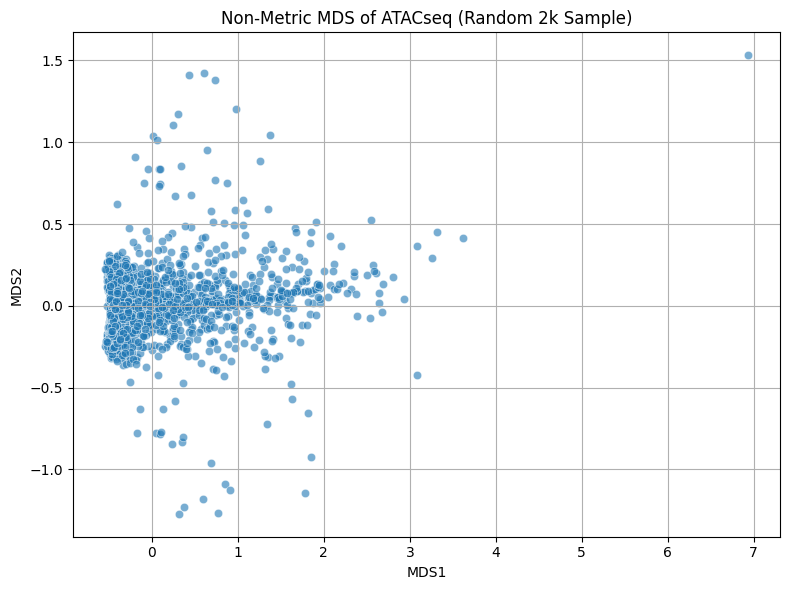

🔍 MDS Summary:
Sample size used: 2000
Original feature count: 21
Stress: 0.06
⚠️ Normalized stress not available (requires scikit-learn >=1.4)
✅ MDS results saved to datasets dictionary.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import euclidean_distances

# === STEP 1: Prepare Random Sample for MDS ===
sample_size = 2000
X_sample = atacseq_clean[bio_cols].sample(n=sample_size, random_state=42)

# === STEP 2: Standardize ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

# === STEP 3: Run Non-Metric MDS ===
nonmetric_mds = MDS(
    n_components=2,
    metric=False,
    dissimilarity='euclidean',
    random_state=42,
    n_init=4,
    max_iter=300,
    n_jobs=-1,
    normalized_stress='auto'  # This ensures normalized stress output (scikit-learn 1.4+
)
X_mds = nonmetric_mds.fit_transform(X_scaled)

# === STEP 4: Save and Visualize ===
mds_df = pd.DataFrame(X_mds, columns=["MDS1", "MDS2"])
plt.figure(figsize=(8, 6))
sns.scatterplot(data=mds_df, x="MDS1", y="MDS2", alpha=0.6)
plt.title("Non-Metric MDS of ATACseq (Random 2k Sample)")
plt.grid(True)
plt.tight_layout()
plt.show()

# === STEP 5: Output Stats ===
print("🔍 MDS Summary:")
print(f"Sample size used: {sample_size}")
print(f"Original feature count: {X_sample.shape[1]}")
print(f"Stress: {nonmetric_mds.stress_:.2f}")
try:
    # Normalized stress (if available)
    print(f"Normalized stress: {nonmetric_mds.normalized_stress_:.4f}")
except:
    print("⚠️ Normalized stress not available (requires scikit-learn >=1.4)")

# === STEP 6: Optional — Save to datasets ===
datasets['mds_df'] = mds_df
datasets['mds_model'] = nonmetric_mds
print("✅ MDS results saved to datasets dictionary.")


AttributeError: 'MDS' object has no attribute 'normalized_stress_'